<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/master/assets/bernstein_basis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from scipy.stats import binom as binom_dist
import matplotlib.pyplot as plt

In [3]:
def bernvander(x, deg):
	return binom_dist.pmf(np.arange(1 + deg), deg, x.reshape(-1, 1))

# Plotting the Bernstein basis

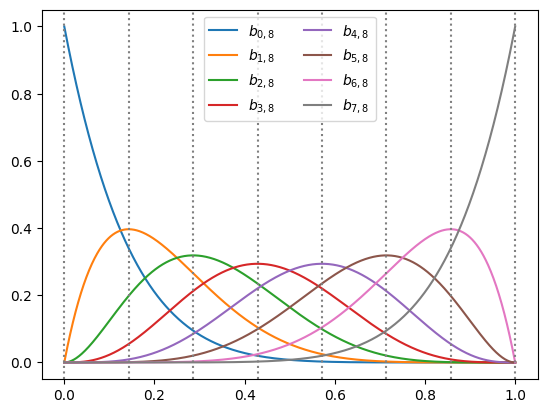

In [4]:
plt_xs = np.linspace(0, 1, 1000)
bernstein_basis = bernvander(plt_xs, deg=7)

plt.plot(plt_xs, bernstein_basis,
         label=[f'$b_{{{i},8}}$' for i in range(8)])
for x in np.linspace(0, 1, 8):
  plt.axvline(x, color='gray', linestyle='dotted')
plt.legend(ncols=2)
plt.show()

# Control points

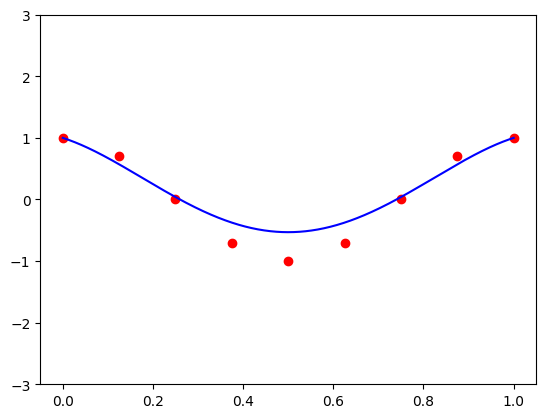

In [5]:
from matplotlib.animation import FuncAnimation, PillowWriter

n = 8
n_frames = 50

ctrl_xs = np.linspace(0, 1, 1 + n)      # the points i / n
w_init = np.cos(2 * np.pi * ctrl_xs)    # initial coefficients
plt_vander = bernvander(plt_xs, deg=n)  # bernstein basis at plot points

fig, ax = plt.subplots()
def animate(i):
  # animate the coefficients "w"
  t = np.sin(2 * np.pi * i / n_frames)
  w = np.array(w_init)
  w[3] = (1 - t) * w[3] + t * 3

  # plot the Bernstein polynomial and the coefficients at i / n
  ax.clear()
  ax.set_xlim([-0.05, 1.05])
  ax.set_ylim([-3, 3])
  control_plot = ax.scatter(ctrl_xs, w, color='red')        # plot control points
  poly_plot = ax.plot(plt_xs, plt_vander @ w, color='blue') # plot the polynomial
  return poly_plot, control_plot

ani = FuncAnimation(fig, animate, n_frames)
ani.save('control_coefficients.gif', dpi=300, writer=PillowWriter(fps=25))

# Nondecreasing Bernstein polynomial

In [46]:
def nondecreasing_func(x):
  return (3 - 2 * x) * (x ** 2) * np.exp(x)

# define number of points and noise
m = 30
sigma = 0.2

np.random.seed(42)
x = np.random.rand(m)
y = nondecreasing_func(x) + sigma * np.random.randn(m)

### Fit with imposed constraints

In [49]:
import cvxpy as cp

deg = 20
u = cp.Variable(deg + 1)                          # a placeholder for the optimal Bernstein coefficients
loss = cp.sum_squares(bernvander(x, deg) @ u - y) # The L2 loss - the sum of residual squares
constraints = [cp.diff(u) >= 0]                   # constraints - u_{i+1} - u_i >= 0
problem = cp.Problem(cp.Minimize(loss), constraints)

# solve the minimization problem and
problem.solve()
u_opt = u.value

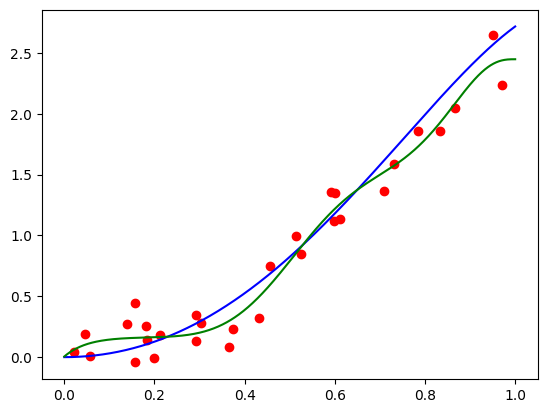

In [48]:
plt.scatter(x, y, color='red')
plt.plot(plt_xs, nondecreasing_func(plt_xs), color='blue')
plt.plot(plt_xs, bernvander(plt_xs, deg) @ u_opt, color='green')

### Fit with 2nd order difference regularization

In [59]:
import cvxpy as cp

deg = 20
alpha = 2

u = cp.Variable(deg + 1)                          # a placeholder for the optimal Bernstein coefficients
loss = cp.sum_squares(bernvander(x, deg) @ u - y) # The L2 loss - the sum of residual squares
reg = alpha * cp.sum_squares(cp.diff(u, 2))       # penalty for 2nd order differences
constraints = [cp.diff(u) >= 0]                   # constraints - u_{i+1} - u_i >= 0
problem = cp.Problem(cp.Minimize(loss + reg), constraints)

# solve the minimization problem and
problem.solve()
u_opt = u.value

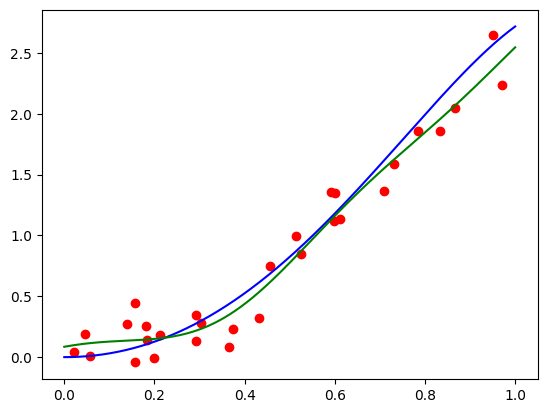

In [60]:
plt.scatter(x, y, color='red')
plt.plot(plt_xs, nondecreasing_func(plt_xs), color='blue')
plt.plot(plt_xs, bernvander(plt_xs, deg) @ u_opt, color='green')

# Fitting using the transition matrix

In [6]:
import numpy as np
from scipy.special import binom

def basis_transition(n):
  ks = np.arange(0, 1 + n)
  js = np.arange(0, 1 + n).reshape(-1, 1)
  Q = binom(js, ks) / binom(n, ks)
  Q = np.tril(Q)
  return Q

In [7]:
import numpy.polynomial.polynomial as poly

def fit_bernstein_reg(x, y, alpha, deg):
  """ Fit a polynomial in the standard basis to the data-points `(x[i], y[i])` with Bernstein
      regularization `alpha`, and degree `deg`.
  """
  V = poly.polyvander(x, deg)
  Q = basis_transition(deg)

  A = V.T @ V + alpha * Q.T @ Q
  b = V.T @ y

  # solve the linear system
  a = np.linalg.solve(A, b)
  return a

In [8]:
def true_func(x):
  return np.sin(8 * np.pi * x) / np.exp(x) + x

# define number of points and noise
m = 30
sigma = 0.1

# generate features
np.random.seed(42)
x = np.random.rand(m)
y = true_func(x) + sigma * np.random.randn(m)

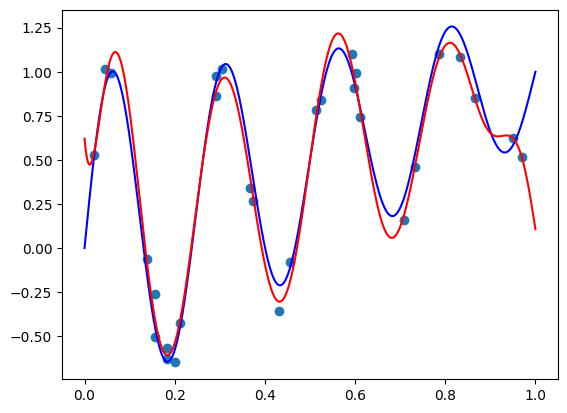

In [9]:
# fit the polynomial
a = fit_bernstein_reg(x, y, 5e-4, deg=50)

# plot the original function, the points, and the fit polynomial
polynomial_ys = poly.polyvander(plt_xs, 50) @ a
plt.scatter(x, y)
plt.plot(plt_xs, true_func(plt_xs), 'blue')
plt.plot(plt_xs, polynomial_ys, 'red')
plt.show()

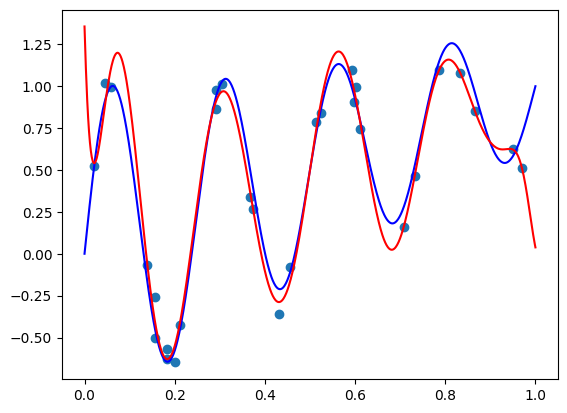

In [10]:
import matplotlib.pyplot as plt

# fit the polynomial
a = fit_bernstein_reg(x, y, 5e-4, deg=100)

# plot the original function, the points, and the fit polynomial
plt_xs = np.linspace(0, 1, 1000)
polynomial_ys = poly.polyvander(plt_xs, 100) @ a
plt.scatter(x, y)
plt.plot(plt_xs, true_func(plt_xs), 'blue')
plt.plot(plt_xs, polynomial_ys, 'red')
plt.show()

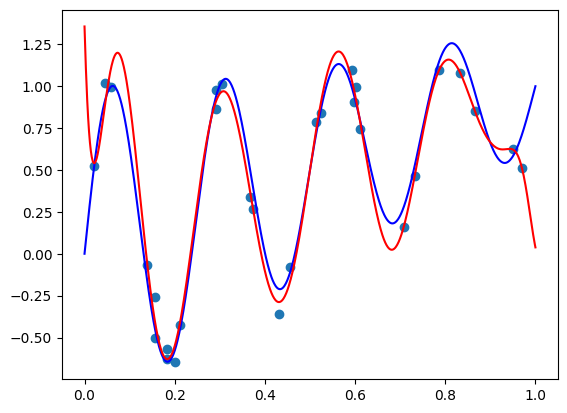

In [11]:
import matplotlib.pyplot as plt

# fit the polynomial
a = fit_bernstein_reg(x, y, 5e-4, deg=100)

# plot the original function, the points, and the fit polynomial
plt_xs = np.linspace(0, 1, 1000)
polynomial_ys = poly.polyvander(plt_xs, 100) @ a
plt.scatter(x, y)
plt.plot(plt_xs, true_func(plt_xs), 'blue')
plt.plot(plt_xs, polynomial_ys, 'red')
plt.show()